In [2]:
import os
import sys
import random

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.io import decode_image
from torchinfo import summary

sys.path.append('../datasets')
from tinyimagenet import TinyImageNetDataset


device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)

print(f"using {device} device")

using cuda device


In [16]:
root_dir = '/home/mateo/Dev/datasets/tiny-imagenet-200'

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = TinyImageNetDataset(root_dir, split='train', use_words=True, transform=transform)

batch_size = 64

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Feature batch shape: torch.Size([64, 3, 64, 64])
Labels batch shape: torch.Size([64])


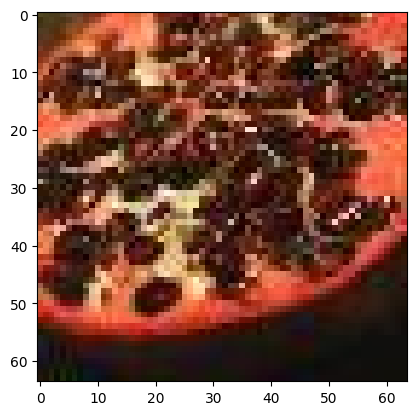

Label: 189


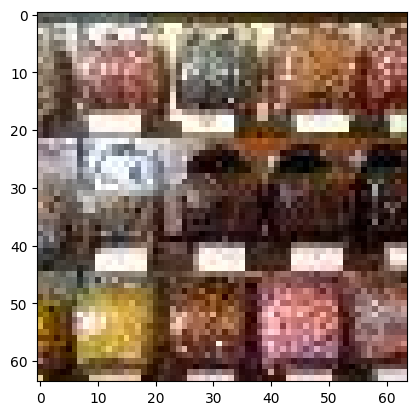

Label: 93


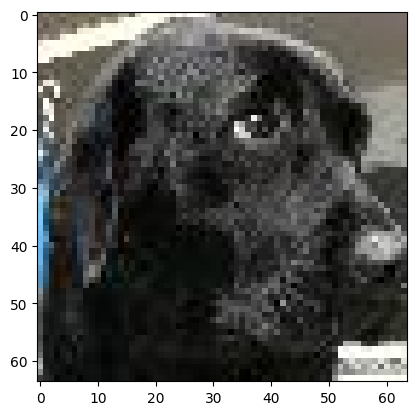

Label: 27


In [17]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
for i in range(3):
    img = np.transpose(train_features[i], (1, 2, 0))
    label = train_labels[i]
    plt.imshow(img, cmap='gray')
    plt.show()
    print(f"Label: {label}")

In [ ]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, pool_proj):
        super(InceptionBlock, self).__init__()

        # branch 1: 1x1 conv branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_1x1, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True)
        )

        # branch 2: 1x1 reduction -> 3x3 conv
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=red_3x3, kernel_size=1, stride=1, padding=0),
            nn.ReLU(in_place=True),
            nn.Conv2d(in_channels=red_3x3, out_channels=out_3x3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(in_place=True)
        )

        # branch 3: 1x1 reduction -> 5x5 conv
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=red_5x5, kernel_size=1, stride=1, padding=0),
            nn.ReLU(in_place=True),
            nn.Conv2d(in_channels=red_5x5, out_channels=out_5x5, kernel_size=5, stride=1, padding=2), # pad 2 to get "same"
            nn.ReLU(in_place=True)
        )

        # branch 4: 3x3 max pool -> 1x1 projection
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=in_channels, out_channels=pool_proj, kernel_size=1, stride=1, padding=0),
            nn.ReLU(in_place=True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        out = torch.cat([branch1, branch2, branch3, branch4], dim=1)
        return out


class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1) # -> 64x64x32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # -> 32x32x32
        # TODO: LRN
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=1) # -> 32x32x96
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=96, kernel_size=3, stride=1, padding=1) # -> 32x32x96
        # TODO: LRN
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # -> 16x16x96

        self.inception3a = InceptionBlock( # -> 16x16x128
            in_channels=96,
            out_1x1=32,
            red_3x3=48,
            out_3x3=64,
            red_5x5=8,
            out_5x5=16,
            pool_proj=16
        )

        self.inception3b = InceptionBlock( # -> 16x16x192
            in_channels=128,
            out_1x1=48,
            red_3x3=48,
            out_3x3=80,
            red_5x5=12,
            out_5x5=40,
            pool_proj=24
        )

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # -> 8x8x192

        self.inception4a = InceptionBlock( # -> 8x8x256
            in_channels=192,
            out_1x1=96,
            red_3x3=48,
            out_3x3=104,
            red_5x5=8,
            out_5x5=24,
            pool_proj=32
        )

        self.inception4b = InceptionBlock( # -> 8x8x256
            in_channels=256,
            out_1x1=80,
            red_3x3=56,
            out_3x3=112,
            red_5x5=12,
            out_5x5=32,
            pool_proj=32
        )

        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # => 4x4x256

        self.inception5a = InceptionBlock( # -> 4x4x512
            in_channels=256,
            out_1x1=160,
            red_3x3=96,
            out_3x3=192,
            red_5x5=20,
            out_5x5=80,
            pool_proj=80
        )

        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1)) # -> 1x1x512
        
        self.fc = nn.Linear(in_features=512, out_features=200)

    def forward(self, x):
        pass